# ANÁLISIS UNIVARIADO DE SERIES DE TIEMPO (BITCOIN) USANDO REDES RNN-LSTM MULTIPASO
#### Análisis unidimensional (univariado) y multipaso de la serie de tiempo del precio de Bitcoin.

<a name="contents"></a>
# Contenido

- [Notas, desconexión y librerías](#conecct)
- [Importando y visualizando datos (información) del bitcoin (y librería opcional en caso de que la usada deje de funcionar)](#data)
- [Función de preparación de datos (univariate_data_multistep)](#univariate_data)
- [Selección y visualización de datos a tratar](#select&PlottingData)
- [Definiendo hiperparámetros y estandarizando los datos](#hyper&Standard)
- [Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow](#Distr&TFFormat)
- [Funciones para graficar predicción y pérdida](#plotFuncts)
- [Función(es) de creación del modelo RNN-LSTM](#modelFunct)
- [PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.](#1stModels)
- [Formato de las predicciones multipaso en un modelo con 8 neuronas.](#multistepPred)
- [Primeras gráficas: Graficando predicciones (de 8, 128 y 256 neuronas) y mostrando errores (MSE)](#1stPredPlots)
- [SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 256 y 512 neuronas)](#sameModels)
- [Caracterizando el error (MSE) con modelos de 256 neuronas](#Errors)
- [Conclusiones e ideas](#Conclu)

<a name="conecct"></a>
# Notas, desconexión y librerías:
- La primera celda es un código que en teoría evita la desconexión de Colab.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Source: https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#0d57
#Stop Colab from disconecting:
#ctl+shift+i -> console -> command lines:
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

In [ ]:
#To import data
#!pip install pandas_datareader #For COLAB #Use if yfinance does not work #import pandas_datareader.data as web
#installing yfinance (Colab)
!pip install yfinance
#pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
#For Bootstrap
!pip install dc_stat_think
import dc_stat_think as dcst
#To use goodness fit test
from scipy import stats
import random
#Data managing
import numpy as np
import os
import pandas as pd
#To comparison forecasts
from sklearn.metrics import mean_squared_error
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#Importing images
from google.colab import files
from io import BytesIO
from PIL import Image
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

#I dont know for what are these packages
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 6.3 MB 43.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=ae6e6d6cda5a0a9cf8ae0f0ce6a9562175bf90dcc38d303e3d2ec950fe33e3b3
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


<a name="data"></a>
# Importando y visualizando datos (información) del Bitcoin:
## Registros diarios (uno por día)
Como se puede ver hay se tienen 2481 registros diarios del Bitcoin desde el 2014 hasta la fecha:

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Univariate time series
#df_btc= web.DataReader("BTC-USD", 'yahoo')#Use if yfinance does not work
print("-------------------------------- DATA -------------------------------")
df_btc = pdr.get_data_yahoo(["BTC-USD"])

print(type(df_btc))
print("---------------------------Head & Tail----------------------------")
print(df_btc.head(2))
print(df_btc.tail(2))
print("---------------------------Description----------------------------")
#NOTE: Check that index is date by default
print(type(df_btc.index))
print(df_btc.describe())
#df_btc.sort_index(ascending=False).head()



-------------------------------- DATA -------------------------------
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
---------------------------Head & Tail----------------------------
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200

[2 rows x 6 columns]
                    Open          High  ...     Adj Close       Volume
Date                                    ...                           
2021-07-19  31800.011719  31885.859375  ...  30817.832031  20434789545
2021-07-21  30802.871094  30982.214844  ...  29741.404297  23057592320

[2 rows x 6 columns]
---------------------------Description----------------------------
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
               Open          High  ...     Adj Close       

## (Opcional) Otra librería (no usada) para importar datos:
La siguiente celda se puede omitir pues solo muestra la aplicación de unos métodos para series de tiempo univariadas (usando Ticker) y como importar series de tiempo multivariadas:

In [ ]:
###NOTE: minimum interval: 1 minute
#------------------------
#Univariate time series
#------------------------
df_btc_T = yf.Ticker("BTC-USD")
#type(df_btc)
#Exploring some methods
#df_btc.info
#df_btc.actions
#df_btc.financials
#df_btc.history(period="max")
#df_btc.calendar
#### valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#df_btc.history(period="2d",interval="1m") 

#-------------------------
#Multivariate time series
#-------------------------

#Several time series
starDate="2017-01-01" #year-month-day
endDate="2017-04-30"
data = web.DataReader("BTC-USD ETH-USD", start=starDate, end=endDate)
print(data)
#print(data["Adj Close"])
#print(type(data["Adj Close"]["BTC-USD"]))
#print(data["Adj Close"]["BTC-USD"])
#dataTickers = yf.Tickers('BTC-USD ETH-USD')
#print(dataTickers.tickers["BTC-USD"].info)
#print(dataTickers.tickers["ETH-USD"].history(period="1mo"))

[*********************100%***********************]  2 of 2 completed


<a name="univariate_data"></a>
# Función de preparación de datos (univariate_data_multistep):
- Para análisis univariado, datos ya estandarizados o normalizados.
- *Idea:* Candidata a exportar.

NOTA: Corregir la imagen de abajo par alo multistep
Volver a [Tabla de contenidos](#contents).

Saving univ_data.jpg to univ_data.jpg


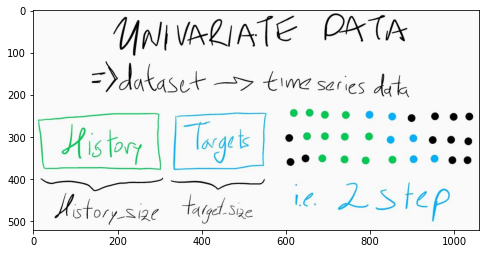

In [ ]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded["univ_data.jpg"]))
plt.imshow(im)

In [ ]:
def univariate_data_multistep(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
  #Generalization of univariate_data function
  ''' 
      dataset: Array containing the whole time series (stadarized or not)
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: size of data to predict
      step:
      single_step:

  '''
  hist = [] #hist = history
  targets = [] 

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    #window = window of time
    window = range(i-history_size,i,step) #it balances the start_index = start_index + history_size made above
    #print(window,i)
    #print(window)
    #Reshape hist from (history_size,) to (history_size,1)
    #hist.append(np.reshape(dataset[window], (history_size, 1))) #len(dataset[window]) = history_size
    hist.append(np.reshape(dataset[window], (len(window), 1))) #prev version commented 1 line above
    #print(hist)
    if single_step:
      targets.append(dataset[i+target_size-1]) #note: the "-1" is not in the original code"
    else:
      targets.append(dataset[i:i+target_size]) #with -1? I did not put it
  return np.array(hist), np.array(targets)

Mirando como trabaja la función univariate_data haciendo una prueba:

In [ ]:
test = np.arange(0,10)
l=range(0,4)
print(type(test))
#print(test)
#print(test[range(0,8,2)]) #equivalent to dataset[window]
#print(np.reshape(test[l], (len(l),1)))
#print(test.shape[])
x,y = univariate_data_multistep(dataset=test, start_index=0, end_index=8, history_size=4,target_size=2, step=2,single_step=False)
print(x)
print(y)
#a = range(-5,5)

<class 'numpy.ndarray'>
[[[0]
  [2]]

 [[1]
  [3]]

 [[2]
  [4]]

 [[3]
  [5]]]
[[4 5]
 [5 6]
 [6 7]
 [7 8]]


<a name="select&PlottingData"></a>
#Selección y visualización de datos a tratar.
### Seleccionando los datos de la serie de tiempo a analizar
- Seleccionando los datos de cierre.
- Gráfica de los datos de entrenamiento y validación.
- Extrayendo los valores del dataframe (se deja de trabajar con un dataframe, y se pasa a trabajar con un array).

Volver a [Tabla de contenidos](#contents).

Date
2021-07-18    31796.810547
2021-07-19    30817.832031
2021-07-21    29741.404297
Name: Adj Close, dtype: float64


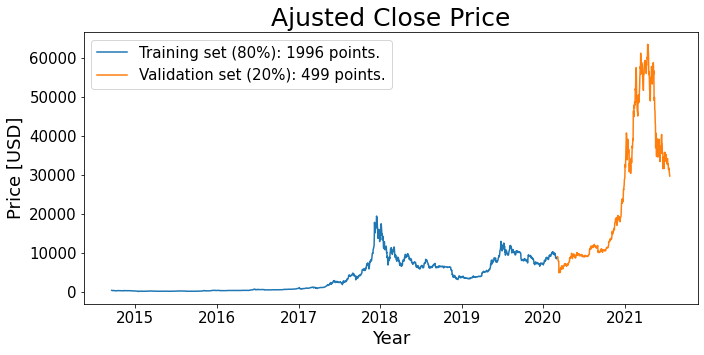

<class 'numpy.ndarray'>


In [ ]:
#Extrating data from data frame:
uni_data = df_btc['Adj Close']
print(uni_data.tail(3))

#Hiperparameter
TRAIN_SPLIT = int(len(df_btc)*0.8)

#Plotting
plt.figure(figsize=(11,5))
plt.plot(uni_data[:TRAIN_SPLIT], label="Training set (80%): "+str(TRAIN_SPLIT)+" points.")
plt.plot(uni_data[TRAIN_SPLIT:], label="Validation set (20%): "+str(len(df_btc)-TRAIN_SPLIT)+" points.")
#plt.plot(uni_data[:TRAIN_SPLIT], label="Conjunto de entrenamiento (80%): "+str(TRAIN_SPLIT)+" datos.")
#plt.plot(uni_data[TRAIN_SPLIT:], label="Conjunto de validación (20%): "+str(len(df_btc)-TRAIN_SPLIT)+" datos.")
plt.title("Ajusted Close Price", size=25)
#plt.title("Precio de cierre ajustado", size=25)
plt.xlabel("Year", size=18)
#plt.xlabel("Año", size=16)
plt.ylabel("Price [USD]", size=18)
#plt.ylabel("Precio [USD]", size=16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

#Extracting data as array
uni_data = uni_data.values
print(type(uni_data))


<a name="hyper&Standard"></a>
# Definiendo hiperparámetros (para la red LSTM) y estandarizando los datos
- *Idea:* Crear una función de estandarización para exportar).
- La estandarización se hace con los datos de entrenamiento.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- HYPERPARAMETERS ----------------------
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
#TRAIN_SPLIT = int(len(df_btc)*0.8) #Put before

#LSTM params
EVALUATION_INTERVAL = 200 #FOR WHAT?
EPOCHS = 100
PATIENCE = 5

#Seeding for reproducibility
SEED = 13
tf.random.set_seed(SEED)

#-------------------- STANDARIZATION ----------------------
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
#print(uni_train_mean)
uni_data = (uni_data - uni_train_mean)/uni_train_std

<a name="Distr&TFFormat"></a>
# Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow 
- La distribución de los datos puede ser lo más importante de todo ya que define la cantidad de paramáteros y como se va a realizar la predicción.
- La transformación de los datos al formato de TF es para el uso de estos en la RNN-LSTM.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- TRAINING AND VALIDATION DATA ----------------------
#Defining history and target size
uni_past_history = 20
uni_future_target = 10 #I DONT KNOW WHY 0 AND NOT 1
STEP = 1#6

#Creating training data
x_train_multi_uni, y_train_multi_uni = univariate_data_multistep(dataset = uni_data, start_index = 0, 
                                           end_index = TRAIN_SPLIT, history_size=uni_past_history,
                                           target_size = uni_future_target, step=STEP)
#Creating validation (for prediction) data
x_val_multi_uni, y_val_multi_uni = univariate_data_multistep(dataset = uni_data, start_index = TRAIN_SPLIT,
                                       end_index = None, history_size = uni_past_history,
                                       target_size = uni_future_target, step=STEP)
#Checking shape
print(uni_data.shape)
print(x_train_multi_uni.shape)
print(y_train_multi_uni.shape)

  #-------------------- DATA IN TENSORFLOW FORMAT ----------------------
#Train data
train_multi_uni = tf.data.Dataset.from_tensor_slices((x_train_multi_uni, y_train_multi_uni))
train_multi_uni = train_multi_uni.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#Validation data
val_multi_uni = tf.data.Dataset.from_tensor_slices((x_val_multi_uni,y_val_multi_uni))
val_multi_uni = val_multi_uni.batch(BATCH_SIZE).repeat()

print(train_multi_uni)
print(val_multi_uni)
print(val_multi_uni.take(1))

(2495,)
(1976, 20, 1)
(1976, 10)
<RepeatDataset shapes: ((None, 20, 1), (None, 10)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None, 10)), types: (tf.float64, tf.float64)>
<TakeDataset shapes: ((None, 20, 1), (None, 10)), types: (tf.float64, tf.float64)>


### Entendiendo la distribución de los datos:

In [ ]:
#Understanding batches and univariate data in tensorflow format
#TRAIN_SPLIT = int(len(df_btc)*0.8)
VAL_SPLIT = len(df_btc) - TRAIN_SPLIT
print(TRAIN_SPLIT,VAL_SPLIT,89+256+20)
#print(type(VAL_SPLIT))
for x,y in val_multi_uni.take(2): #x and y are the 2 batches of data
  print(len(x))
  #print(x)
  print(x[0])
  print(x[1])
  print("YYYYYYYYY")
  print(y)

1991 498 365
256
tf.Tensor(
[[1.16998084]
 [1.16071887]
 [1.23750869]
 [1.21704151]
 [1.208908  ]
 [1.28977227]
 [1.30071606]
 [1.24757789]
 [1.04715529]
 [1.00104585]
 [0.99756773]
 [0.99799283]
 [0.26296754]
 [0.41117001]
 [0.32035151]
 [0.36832987]
 [0.2738885 ]
 [0.32666615]
 [0.32986783]
 [0.56801261]], shape=(20, 1), dtype=float64)
tf.Tensor(
[[1.16071887]
 [1.23750869]
 [1.21704151]
 [1.208908  ]
 [1.28977227]
 [1.30071606]
 [1.24757789]
 [1.04715529]
 [1.00104585]
 [0.99756773]
 [0.99799283]
 [0.26296754]
 [0.41117001]
 [0.32035151]
 [0.36832987]
 [0.2738885 ]
 [0.32666615]
 [0.32986783]
 [0.56801261]
 [0.56990862]], shape=(20, 1), dtype=float64)
YYYYYYYYY
tf.Tensor(
[[0.56990862]
 [0.56648128]
 [0.47779471]
 [0.62428278]
 [0.70389032]
 [0.69045761]
 [0.69930035]
 [0.63765117]
 [0.58076051]
 [0.50073751]
 [0.62766387]
 [0.62986415]
 [0.67188937]
 [0.71859282]
 [0.70353626]
 [0.73706513]
 [0.71796915]
 [0.83811001]
 [0.81427272]
 [0.85368649]
 [0.84568564]
 [0.73655667]
 [0.7349

<a name="plotFuncts"></a>
# Funciones para graficar predicción y pérdida
- Función que grafica una predicción corta (de cada BATCH).
- Función que grafica la pérdida para los datos de entrenamiento y validación.
- *Candidatas a exportar* 

Volver a [Tabla de contenidos](#contents).

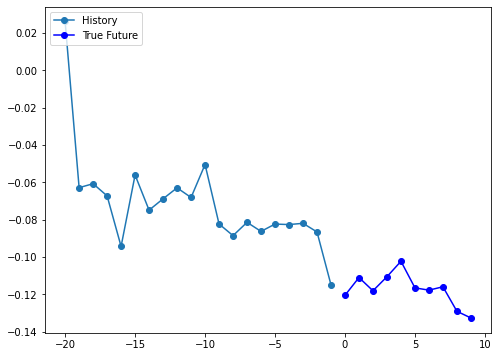

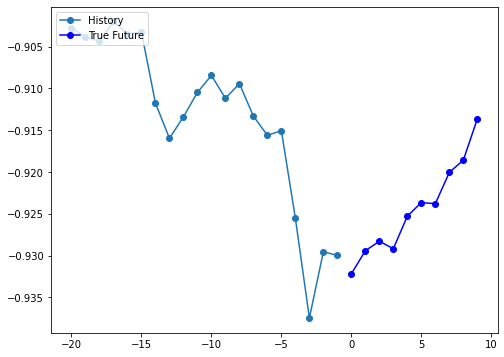

In [ ]:
def create_time_steps(length):
  return list(range(-length,0))

def multi_step_plot(history, true_future, prediction):
  '''
      history: .
      true_future:  
      prediction: .
  '''
  plt.figure(figsize=(8,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  #why history[:,1] i.e. why col one ?
  plt.plot(num_in, np.array(history),'-o',label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future),'-bo', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction),'-ro', label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()  

#Testing function
##plot_short_pred([x_train_multi_uni[0], y_train_multi_uni[0]], 0, 'Sample Example')
for x,y in train_multi_uni.take(2):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
#understanding create_time_steps
#print(list(range(-10,0)))
#---- Enumerate
a = [[[1,2,3,4,5]],[[10]],[[20,30,40]]]
print(a)
#print(type(a))
#print(a[0].flatten()) #error, because a[0] is not a column
#print(enumerate(a))
#enumerate is like a vector of couples like: (index, data)
for i,x in enumerate(a):
  print(i)
  print(x)
  print("end")
#----- numbers, boolean, conditional values and if
print(1==True)
print(0==False)
print(2==False)
if 3:
  print("a")

[[[1, 2, 3, 4, 5]], [[10]], [[20, 30, 40]]]
0
[[1, 2, 3, 4, 5]]
end
1
[[10]]
end
2
[[20, 30, 40]]
end
True
True
False
a


## Función que gráfica la perdida en los datos de entrenamiento y validación

In [ ]:
def plot_loss(history, title):
  #print(history.history)
  loss = history.history['loss']
  #print(loss)
  val_loss = history.history['val_loss']
  #print(val_loss)

  epochs = range(len(loss))
  #print(epochs)

  #1st y axis (training loss)
  fig, ax1 = plt.subplots()
  col1 = "red"
  ax1.set_xlabel("Epoch", size=15)
  ax1.set_ylabel("Training Loss", color=col1, size=20)
  ax1.plot(epochs,loss, color=col1, marker = 'o')
  ax1.tick_params(axis='y', labelcolor=col1)

  #2nd y axis (val loss)
  ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
  col2 = "blue"
  ax2.set_ylabel("Val. Loss", color=col2, size=20)
  ax2.plot(epochs, val_loss, color=col2, marker = "o")
  ax2.tick_params(axis='y', labelcolor=col2)
  plt.title(title, size=19)
  #fig.tight_layout()
  plt.show()

<a name="modelFunct"></a>
# Función(es) de creación del modelo RNN-LSTM
- Es un modelo con una capa intermedia.
- El modelo tiene como un argumento el número de neuronas de la capa intermedia.
- *Candidata a exportar*.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def my_model_multi(n_of_neurons, in_shape, n_steps):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=n_of_neurons, input_shape=in_shape))
  model.add(tf.keras.layers.Dense(n_steps))
  return model

<a name="1stModels"></a>
#PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.
- Para c/modelo se obtiene la gráfica de perdida para el entrenamiento y la validación.

Para el modelo de 8 neuronas se mostró:
- Resumen (summary) del modelo de 8 neuronas.
- Gráfica de compración de los datos versus predicción corta.

Volver a [Tabla de contenidos](#contents).


### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 8 neuronas en su capa intermedia

In [ ]:
%%time
tf.keras.backend.clear_session()
multi_step_1D_model = my_model_multi(n_of_neurons=8, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')#different in 2D model

#training
#To Stop training when a monitored metric has stopped improving.
#Patience: Number of epochs with no improvement after which training will be stopped.
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)
#what steps_per_epoch mean?, what callbacks?, whats validation_step ?

#saving predictions (8 neurons)
predictions8U = multi_step_1D_model.predict(x_val_multi_uni)

Epoch 1/100
200/200 [==============================] - 9s 7ms/step - loss: 0.6441 - val_loss: 4.6840
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1750 - val_loss: 4.0055
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0997 - val_loss: 3.7544
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0871 - val_loss: 3.6075
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0821 - val_loss: 3.4963
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0794 - val_loss: 3.4244
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0780 - val_loss: 3.3800
Epoch 8/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0772 - val_loss: 3.3442
Epoch 9/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0764 - val_loss: 3.3243
Epoch 10/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0759 - val_lo

<a name="multistepPred"></a>
#Formato de las predicciones multipaso en un modelo con 8 neuronas.

Volver a [Tabla de contenidos](#contents).

[[0.75417745 0.74948907 0.73663133 ... 0.7355148  0.74071443 0.7308793 ]
 [0.7107351  0.7136505  0.7019012  ... 0.7119963  0.71078664 0.70524955]
 [0.69924855 0.70656043 0.7001501  ... 0.7122176  0.7063289  0.7045986 ]
 ...
 [4.084135   4.068907   3.9513478  ... 3.7246628  3.6806767  3.527324  ]
 [4.0848103  4.064307   3.9500515  ... 3.7198534  3.681948   3.528131  ]
 [4.0821905  4.0653667  3.9506824  ... 3.7212145  3.679036   3.5257835 ]]
[[0.68708076 0.69591869 0.63430303 ... 0.66852262 0.71520067 0.7001523 ]
 [0.69591869 0.63430303 0.5774433  ... 0.71520067 0.7001523  0.73366294]
 [0.63430303 0.5774433  0.49746381 ... 0.7001523  0.73366294 0.71457734]
 ...
 [7.23139302 7.46138572 7.39206315 ... 6.95743233 6.86769981 6.89556185]
 [7.46138572 7.39206315 7.57184924 ... 6.86769981 6.89556185 6.96144942]
 [7.39206315 7.57184924 7.30096151 ... 6.89556185 6.96144942 6.71688286]]


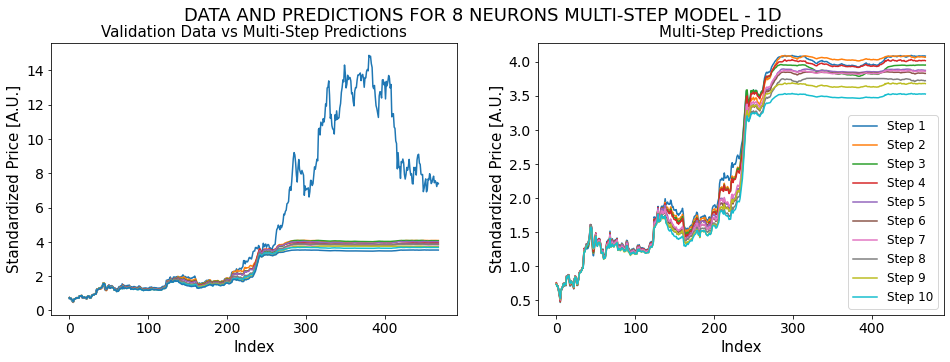

In [ ]:
print(predictions8U)
print(y_val_multi_uni)
#print(len(predictions8U[0,:]))
#print(predictions8U[0,:])
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,5))
fig.suptitle("DATA AND PREDICTIONS FOR 8 NEURONS MULTI-STEP MODEL - 1D", size = 18)
ax1.set_title("Validation Data vs Multi-Step Predictions", size=15)
ax1.set_ylabel("Standardized Price [A.U.]", size=15)
ax1.set_xlabel("Index", size=15)
ax1.plot(y_val_multi_uni[:,0])
ax1.plot(predictions8U, label="s")
ax1.tick_params(labelsize = 14)
#plt.show()
ax2.set_title("Multi-Step Predictions", size=15)
ax2.set_ylabel("Standardized Price [A.U.]", size=15)
ax2.set_xlabel("Index", size=15)
#ax2.set_xlim(0,11)
#ax2.set_xlim(380,420)
#ax2.plot(predictions8U)
for i in range(len(predictions8U[0,:])): 
  ax2.plot(predictions8U[:,i], label="Step "+str(i+1))
ax2.tick_params(labelsize = 14)
plt.legend(fontsize = 12)
plt.show()

# NOTA: Algo raro
Las predicciones de cada paso deben estar desplazadas a la derecha entre mas grande sea el paso que se analiza, y esto no parece suceder (ver la gráfica anterior). Además, ver como son los datos de validación de la variable 'y' (target) y como se obtiene el MSE.

In [ ]:
print("--------- Parameters for 8 neurons model ---------")
print(multi_step_1D_model.summary())
#This is to understand the number of params
#print(320/8)
#print(x_train_multi_uni.shape[-2:])
#single_step_1D_model = my_model(n_of_neurons=16, in_shape=x_train_multi_uni.shape[-2:])
#single_step_1D_model.compile(optimizer='adam', loss='mae')
#print(single_step_1D_model.summary())
#print(1152/16)

--------- Parameters for 8 neurons model ---------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 10)                90        
Total params: 410
Trainable params: 410
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(single_step_1D_model_history.history['loss'])
#single_step_1D.history.history

[0.3489745259284973, 0.0964616909623146, 0.07418343424797058, 0.06463509798049927, 0.058282747864723206, 0.05461755767464638, 0.05257461965084076, 0.05116093158721924, 0.05018441751599312, 0.04965312406420708, 0.04919809848070145, 0.04891252517700195, 0.048690248280763626, 0.048465874046087265, 0.04846302047371864, 0.048350997269153595, 0.04823753982782364, 0.04813843220472336, 0.04805613309144974, 0.04829820990562439, 0.048048656433820724, 0.04795398563146591, 0.04800897836685181, 0.047763265669345856, 0.047837648540735245, 0.04774798825383186, 0.04765057936310768, 0.047670427709817886, 0.04772907868027687, 0.04762404039502144, 0.047500159591436386, 0.04765516147017479, 0.04751081392168999, 0.04759000241756439, 0.04738340899348259, 0.04745016619563103, 0.04730279743671417, 0.04752323776483536, 0.04736172407865524, 0.04735783487558365, 0.04731203243136406, 0.0473097562789917, 0.04732930287718773, 0.047320831567049026, 0.047270819544792175, 0.04724656045436859, 0.04717181995511055, 0.04

### Gráfica de la pérdida en función de las epochs

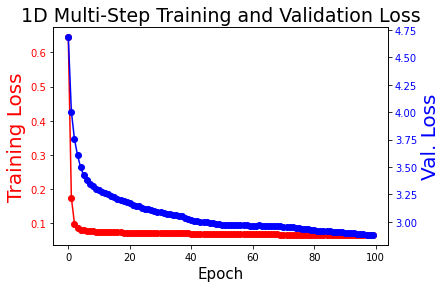

In [ ]:
plot_loss(history=multi_step_1D_model_history, title='1D Multi-Step Training and Validation Loss')

In [ ]:
#Checking prediction shape
for x,y in val_multi_uni.take(1):
  print(multi_step_1D_model.predict(x).shape)
  #print(simple_lstm_model.predict(x))

(256, 10)


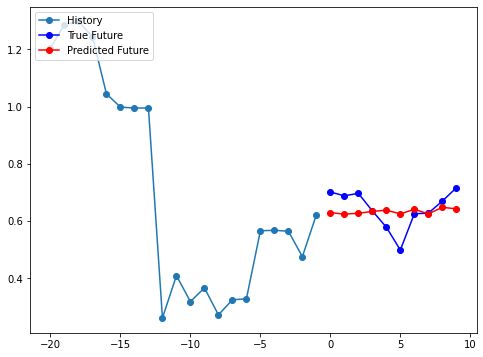

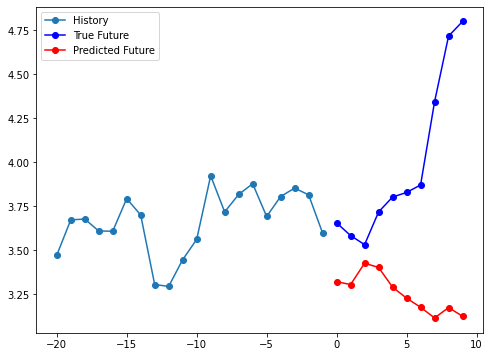

In [ ]:
#print(val_univariate.take(1))
#val_univariate.take(k) is like a vector of k first components containing (x_val,y_val) 
for x,y in val_multi_uni.take(2):
  multi_step_plot(x[0],y[0], multi_step_1D_model.predict(x)[0])

In [ ]:
#deleting model
del multi_step_1D_model, multi_step_1D_model_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 128 neuronas en su capa intermedia (en forma sucinta).

In [ ]:
%%time
tf.keras.backend.clear_session()
multi_step_1D_model = my_model_multi(n_of_neurons=128, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')#different in 2D model

#training
#To Stop training when a monitored metric has stopped improving.
#Patience: Number of epochs with no improvement after which training will be stopped.
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)
#what steps_per_epoch mean?, what callbacks?, whats validation_step ?

#saving predictions (128 neurons)
predictions128U = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model

Epoch 1/100
200/200 [==============================] - 3s 8ms/step - loss: 0.1393 - val_loss: 2.7542
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0885 - val_loss: 2.4574
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0793 - val_loss: 2.1881
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0746 - val_loss: 2.0591
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0718 - val_loss: 1.9976
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0693 - val_loss: 1.8890
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0678 - val_loss: 1.8192
Epoch 8/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 1.7897
Epoch 9/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 1.7461
Epoch 10/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0651 - val_lo

### Gráfica de la pérdida en función de las epochs

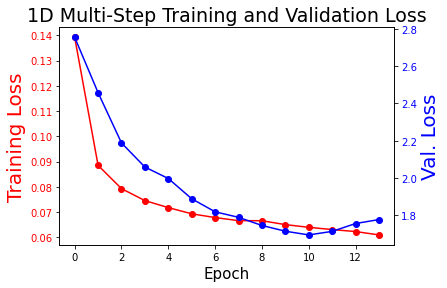

In [ ]:
plot_loss(multi_step_1D_model_history, '1D Multi-Step Training and Validation Loss')
del multi_step_1D_model_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 256 neuronas en su capa intermedia.

In [ ]:
%%time
tf.keras.backend.clear_session()
multi_step_1D_model = my_model_multi(n_of_neurons=256, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')#different in 2D model

#training
#To Stop training when a monitored metric has stopped improving.
#Patience: Number of epochs with no improvement after which training will be stopped.
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)
#what steps_per_epoch mean?, what callbacks?, whats validation_step ?

#saving predictions (128 neurons)
predictions256U = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model

Epoch 1/100
200/200 [==============================] - 4s 11ms/step - loss: 0.1289 - val_loss: 2.1583
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0887 - val_loss: 1.7833
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0812 - val_loss: 1.3891
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0744 - val_loss: 1.3585
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0718 - val_loss: 1.3954
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0692 - val_loss: 1.3453
Epoch 7/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0669 - val_loss: 1.3596
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0637 - val_loss: 1.3131
Epoch 9/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0634 - val_loss: 1.2923
Epoch 10/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0617 - val_l

### Gráfica de la pérdida en función de las epochs

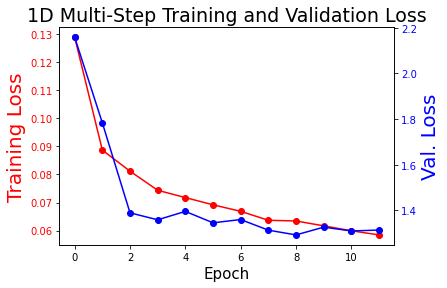

In [ ]:
plot_loss(history=multi_step_1D_model_history, title='1D Multi-Step Training and Validation Loss')
del multi_step_1D_model_history

<a name="1stPredPlots"></a>
# Primeras gráficas: Graficando predicciones (8, 128 y 256 neuronas) y mostrando errores (MSE)
- Gráficas de las predicciones de los modelos hechos anteriormente.

Volver a [Tabla de contenidos](#contents).

### Configurando dataframes para obtener series de tiempo (y no solo arrays):

In [ ]:
##To plot train and validation data together with models predictions

#------- Creating dframes (to work with time series) with standirized data
#dframes lengths
N = len(df_btc)
M = len(predictions8U)

#data dataframe
data_std = pd.DataFrame(index=df_btc.index,columns=['AdjCloStd']) #standarized #try to change index to date since this line
train = data_std[:TRAIN_SPLIT]
valid = data_std[TRAIN_SPLIT:]

#predictions dataframe
predictions = pd.DataFrame(index=df_btc.tail(M).index,columns=['Pred8U', 'Pred128U', 'Pred256U'])#try to change index to date since this line

#Filling data dataframe
for i in range(0,N):
  data_std['AdjCloStd'][i] = uni_data[i]

#Filling predictions dataframe
predictions['Pred8U'] = predictions8U
predictions['Pred128U'] = predictions128U
predictions['Pred256U'] = predictions256U

### Mirando el formato de las predicciones

In [ ]:
print(predictions8U)
print(predictions['Pred8U'])
print(predictions128U)
print(predictions256U)

[[0.5966202  0.60723704 0.5934752  ... 0.60450196 0.59234726 0.60657984]
 [0.57119596 0.57256466 0.56352127 ... 0.5802321  0.577741   0.5921766 ]
 [0.47742054 0.4689999  0.46629936 ... 0.4884023  0.49079725 0.505863  ]
 ...
 [3.6121566  3.3957384  3.318042   ... 3.0523584  2.9990363  3.0852168 ]
 [3.6133332  3.3959334  3.31969    ... 3.0520098  2.999583   3.0853992 ]
 [3.6140985  3.3959293  3.3209734  ... 3.0516396  3.0000741  3.0855246 ]]
Date
2020-03-31    0.596620
2020-04-01    0.571196
2020-04-02    0.477421
2020-04-03    0.617548
2020-04-04    0.725727
                ...   
2021-07-11    3.613911
2021-07-12    3.611705
2021-07-13    3.612157
2021-07-14    3.613333
2021-07-16    3.614099
Name: Pred8U, Length: 468, dtype: float32
[[0.5950488  0.6121463  0.64552397 ... 0.68293417 0.7382422  0.7141676 ]
 [0.58014023 0.60359645 0.6369795  ... 0.6667292  0.7269272  0.6977714 ]
 [0.4850098  0.510602   0.5378102  ... 0.57432956 0.6283472  0.5993446 ]
 ...
 [6.6763806  5.7038465  6.561961

### Graficando serie de tiempo y predicciones:

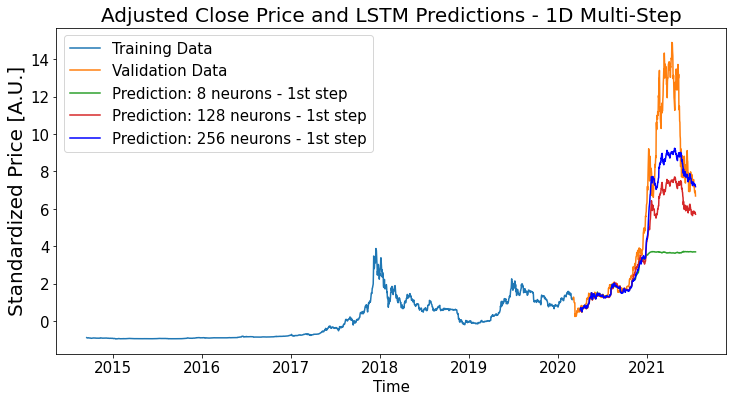

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['AdjCloStd'], label="Training Data")
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="Prediction: 8 neurons - 1st step")
plt.plot(predictions['Pred128U'], label="Prediction: 128 neurons - 1st step")
plt.plot(predictions['Pred256U'], label="Prediction: 256 neurons - 1st step", color='blue')
plt.title("Adjusted Close Price and LSTM Predictions - 1D Multi-Step", size=20)
plt.ylabel("Standardized Price [A.U.]", size=20)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

### Graficando datos de validación y predicciones

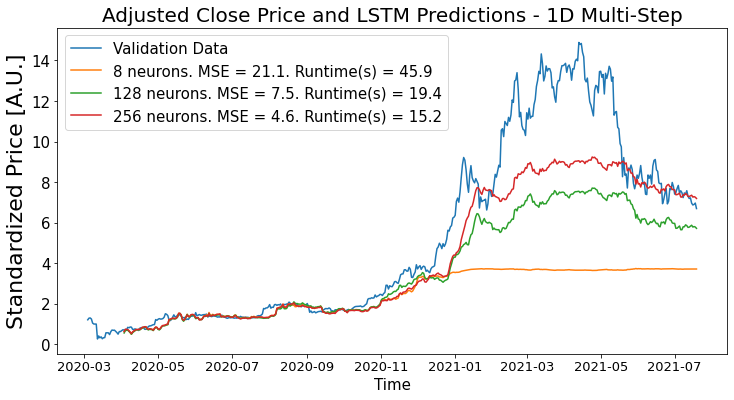

In [ ]:
#training time
T_8U = 45.9
T_128U = 19.4
T_256U = 15.2

#MSE Calculations
MSE_8U = round(mean_squared_error(y_val_multi_uni, predictions8U , squared=True),1) 
MSE_128U = round(mean_squared_error(y_val_multi_uni, predictions128U , squared=True),1)
MSE_256U = round(mean_squared_error(y_val_multi_uni, predictions256U , squared=True),1)

#Plotting
plt.figure(figsize=(12,6))
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="8 neurons. MSE = "+str(MSE_8U)+". Runtime(s) = "+str(T_8U))
plt.plot(predictions['Pred128U'], label="128 neurons. MSE = "+str(MSE_128U)+". Runtime(s) = "+str(T_128U))
plt.plot(predictions['Pred256U'], label="256 neurons. MSE = "+str(MSE_256U)+". Runtime(s) = "+str(T_256U))
plt.title("Adjusted Close Price and LSTM Predictions - 1D Multi-Step", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()
#print(y_train_uni.size)
#print(y_val_uni.size)

<a name="sameModels"></a>
# SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 256, 1024 y 2048 neuronas)
- Se muestran gráficas de predicciones de 9 modelos: 3 con 256 neuronas, 3 con 1024 neuronas y 3 con 2048.
- Nota: Ya no se observa que desde 2048 hacia arriba el resultado de la predicción cambiara mucho al correr el modelo varias veces. Esto se puede deber a validation_steps=EVALUATION_INTERVAL, y no validation_steps=50 como se hizo inicialmente.

Volver a [Tabla de contenidos](#contents).

##Para 256 neuronas:

In [ ]:
%%time
tf.keras.backend.clear_session()
units=256
###################### 1ND MODEL ##################################
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_1 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_2 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_3 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

Epoch 1/100
200/200 [==============================] - 10s 11ms/step - loss: 0.1308 - val_loss: 2.3328
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0871 - val_loss: 1.7944
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0818 - val_loss: 1.5099
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0748 - val_loss: 1.4985
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0717 - val_loss: 1.5461
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0683 - val_loss: 1.4179
Epoch 7/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0668 - val_loss: 1.3764
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0652 - val_loss: 1.3837
Epoch 9/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0632 - val_loss: 1.3625
Epoch 10/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0619 - val_

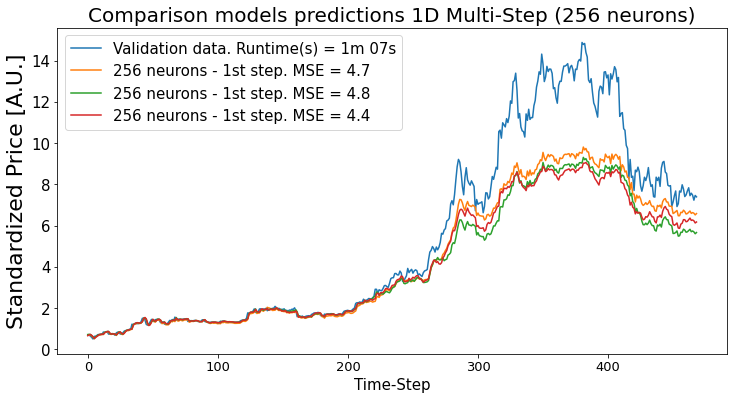

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_256U_1 = round(mean_squared_error(y_val_multi_uni, predictions256U_1 , squared=True),1)
MSE_256U_2 = round(mean_squared_error(y_val_multi_uni, predictions256U_2 , squared=True),1)
MSE_256U_3 = round(mean_squared_error(y_val_multi_uni, predictions256U_3 , squared=True),1) 

#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_multi_uni[:,0], label="Validation data. Runtime(s) = 1m 07s")
plt.plot(predictions256U_1[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_1))
plt.plot(predictions256U_2[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_2))
plt.plot(predictions256U_3[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_3))
plt.title("Comparison models predictions 1D Multi-Step (256 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

#Para 1024 neuronas (problemático en el modelo de un paso):
- Tiempo en correr 3 modelos: 

In [ ]:
%%time
tf.keras.backend.clear_session()
units=1024
###################### 1ND MODEL ##################################
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions1024U_1 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions1024U_2 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions1024U_3 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

Epoch 1/100
200/200 [==============================] - 12s 50ms/step - loss: 0.1667 - val_loss: 1.7364
Epoch 2/100
200/200 [==============================] - 10s 49ms/step - loss: 0.0963 - val_loss: 1.3505
Epoch 3/100
200/200 [==============================] - 10s 49ms/step - loss: 0.0839 - val_loss: 1.3447
Epoch 4/100
200/200 [==============================] - 10s 50ms/step - loss: 0.0804 - val_loss: 0.9818
Epoch 5/100
200/200 [==============================] - 10s 50ms/step - loss: 0.0743 - val_loss: 0.8098
Epoch 6/100
200/200 [==============================] - 10s 50ms/step - loss: 0.0699 - val_loss: 1.0107
Epoch 7/100
200/200 [==============================] - 10s 51ms/step - loss: 0.0668 - val_loss: 0.9319
Epoch 8/100
200/200 [==============================] - 10s 51ms/step - loss: 0.0663 - val_loss: 0.9927
Epoch 1/100
200/200 [==============================] - 12s 53ms/step - loss: 0.1398 - val_loss: 1.4354
Epoch 2/100
200/200 [==============================] - 10s 51ms/step - lo

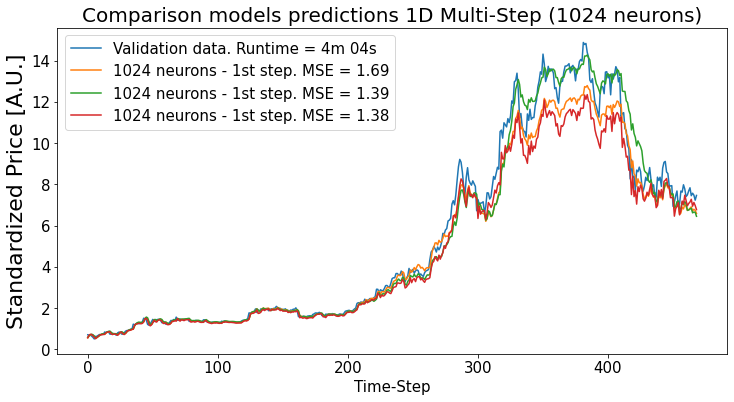

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_1024U_1 = round(mean_squared_error(y_val_multi_uni, predictions1024U_1 , squared=True),2)
MSE_1024U_2 = round(mean_squared_error(y_val_multi_uni, predictions1024U_2 , squared=True),2)
MSE_1024U_3 = round(mean_squared_error(y_val_multi_uni, predictions1024U_3 , squared=True),2) 

#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_multi_uni[:,0], label="Validation data. Runtime = 4m 04s")
plt.plot(predictions1024U_1[:,0], label="1024 neurons - 1st step. MSE = "+str(MSE_1024U_1))
plt.plot(predictions1024U_2[:,0], label="1024 neurons - 1st step. MSE = "+str(MSE_1024U_2))
plt.plot(predictions1024U_3[:,0], label="1024 neurons - 1st step. MSE = "+str(MSE_1024U_3))
plt.title("Comparison models predictions 1D Multi-Step (1024 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

#Para 2048 neuronas (problemático en el modelo de un paso):
- Tiempo en correr 3 modelos: 16min 34s


In [ ]:
#Aquí quedé
%%time
tf.keras.backend.clear_session()
units=2048
###################### 1ND MODEL ##################################
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_1 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_2 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_1D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
multi_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_multi_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_3 = multi_step_1D_model.predict(x_val_multi_uni)

#deleting model
del multi_step_1D_model, multi_step_1D_model_history

Epoch 1/100
200/200 [==============================] - 46s 190ms/step - loss: 0.2193 - val_loss: 2.2490
Epoch 2/100
200/200 [==============================] - 38s 189ms/step - loss: 0.1034 - val_loss: 1.7845
Epoch 3/100
200/200 [==============================] - 37s 188ms/step - loss: 0.0906 - val_loss: 1.3761
Epoch 4/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0834 - val_loss: 0.8083
Epoch 5/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0778 - val_loss: 0.8486
Epoch 6/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0724 - val_loss: 0.7058
Epoch 7/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0698 - val_loss: 0.7217
Epoch 8/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0658 - val_loss: 0.8226
Epoch 9/100
200/200 [==============================] - 38s 189ms/step - loss: 0.0630 - val_loss: 0.7195
Epoch 1/100
200/200 [==============================] - 40s 192ms

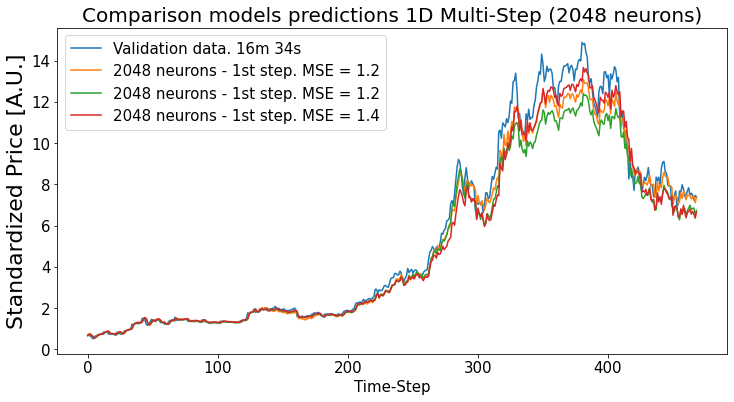

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_2048U_1 = round(mean_squared_error(y_val_multi_uni, predictions2048U_1 , squared=True),1)
MSE_2048U_2 = round(mean_squared_error(y_val_multi_uni, predictions2048U_2 , squared=True),1)
MSE_2048U_3 = round(mean_squared_error(y_val_multi_uni, predictions2048U_3 , squared=True),1) 

#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_multi_uni[:,0], label="Validation data. 16m 34s")
plt.plot(predictions2048U_1[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_1))
plt.plot(predictions2048U_2[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_2))
plt.plot(predictions2048U_3[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_3))
plt.title("Comparison models predictions 1D Multi-Step (2048 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

<a name="Errors"></a>

#Caracterizando el error (MSE) con modelos de 256 neuronas
- Se hicieron 100 número de simulaciones y se guardó el valor del MSE de cada simulación (en la variable errors).
- Histograma de los errores.
- Pruebas de normalidad.
- Bootstap (intervalo de confianza).

Volver a [Tabla de contenidos](#contents).

In [ ]:
%%time
N_SIM = 100
errors = []
for i in range(N_SIM):
  print("Simulation:"+str(i))
  tf.keras.backend.clear_session()
  multi_step_1D_model = my_model_multi(n_of_neurons=256, in_shape=x_train_multi_uni.shape[-2:], n_steps=uni_future_target)
  multi_step_1D_model.compile(optimizer='adam', loss='mae')

  #Training
  P = 3
  early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
  multi_step_1D_model_history = multi_step_1D_model.fit(train_multi_uni,
                                                      epochs=EPOCHS,
                                                      steps_per_epoch=EVALUATION_INTERVAL,
                                                      validation_data=val_multi_uni,
                                                      callbacks=[early_stopping],
                                                      validation_steps=EVALUATION_INTERVAL)
  
  #saving predictions (256 neurons)
  predictions256U = multi_step_1D_model.predict(x_val_multi_uni)
  
  #Calculating and saving errors
  MSE = round(mean_squared_error(y_val_multi_uni, predictions256U , squared=True),2)
  errors.append(MSE)

  #deleting model
  del multi_step_1D_model, multi_step_1D_model_history

print(errors)

Simulation:0
Epoch 1/100
200/200 [==============================] - 4s 12ms/step - loss: 0.1295 - val_loss: 2.2543
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0881 - val_loss: 1.7301
Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0809 - val_loss: 1.4652
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0762 - val_loss: 1.2264
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0738 - val_loss: 1.2483
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0697 - val_loss: 1.1996
Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0672 - val_loss: 1.2206
Epoch 8/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0652 - val_loss: 1.2364
Epoch 9/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0641 - val_loss: 1.2738
Simulation:1
Epoch 1/100
200/200 [==============================] - 4s 

### Histograma de los errores, pruebas de normalidad, bootstap (intervalo de confianza)

---------- Histograma ----------
100


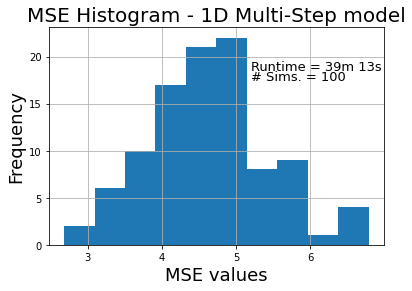

---------- Normality tests ----------
Shapiro-Wilk p-value for MSE:  0.43832191824913025
Kolmogorov-Smirnov p-value for MSE:  7.922934097816932e-244
---------- Bootstrap ----------
4.619500000000001
[4.4635975 4.7766   ]
0.3130025000000014


In [ ]:
#Errors:
print("---------- Histograma ----------")
xt = 5.2
#errors = [3.9, 5.13, 5.18, 4.57, 5.47, 3.94, 4.1, 3.71, 3.4, 4.32, 5.09, 4.59, 4.39, 5.2, 4.35, 4.76, 6.05, 5.01, 5.6, 5.75, 3.85, 4.1, 4.31, 3.81, 4.09, 4.09, 4.18, 4.42, 4.81, 4.03, 4.83, 6.55, 3.52, 5.12, 4.22, 5.63, 4.98, 5.67, 5.05, 4.17, 5.41, 3.84, 4.81, 2.92, 4.81, 3.77, 4.61, 4.33, 4.88, 3.77, 4.5, 5.5, 4.48, 4.76, 3.74, 3.95, 4.56, 5.23, 4.51, 5.05, 4.59, 5.89, 6.79, 5.66, 4.8, 4.91, 3.68, 4.4, 3.44, 3.38, 4.05, 5.72, 5.38, 4.49, 4.43, 4.86, 6.38, 4.04, 4.43, 4.46, 4.2, 2.68, 5.21, 4.82, 4.45, 4.57, 6.68, 5.11, 4.35, 4.28, 4.83, 4.82, 4.54, 3.41, 4.77, 3.47, 5.6, 5.61, 4.18, 3.22]
print(len(errors))
plt.hist(errors)
#plt.title("Histograma de los Errores Cuadráticos Medios de Modelos 1D")
#plt.ylabel("Cuentas")
#plt.xlabel("Valores de MSE")
plt.title("MSE Histogram - 1D Multi-Step model", size = 20)
plt.ylabel("Frequency", size = 18)
plt.xlabel("MSE values", size = 18)
plt.text(xt, 18.5, "Runtime = 39m 13s", size = 13)
plt.text(xt, 17.5, "# Sims. = 100", size = 13)
plt.grid(True)
plt.show()

print("---------- Normality tests ----------")
staB, pvalB = stats.shapiro(errors)
print("Shapiro-Wilk p-value for MSE: ",pvalB)
staB, pvalB = stats.kstest(errors,'norm')
print("Kolmogorov-Smirnov p-value for MSE: ",pvalB)

print("---------- Bootstrap ----------")
random.seed(10)
bs_reps = dcst.draw_bs_reps(errors, np.mean, size = 10000)
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print(np.mean(errors))
#print(np.median(errors256))
print(conf_int)
#print(conf_int-np.mean(errors256))
print(conf_int[1]-conf_int[0])

<a name="Conclu"></a>
#Conclusiones e ideas
### Conclusiones:
1. El modelo logra mejores predicciones cuando tiene mas neuronas en su capa intermedia y no sus predicciones no se "estallan" como en los modelos multipaso.
2. El mejor modelo logrado es el multipaso univariado con 2048 neuronas en su capa intermedia pero el entrenamiento de este modelo se demora aproximadamente 6 minutos.
3. Los resultados de las predicciones no son 100% repetibles. 
4. El intervalo de confianza (con un nivel de confianza del 95%) para la media del error de la predicción de las series unidimensionales a un paso en un modelo con 256 neuronas en su capa intermedia es 4.62 +/- (4.46, 4.77) con un $\Delta$Error = 0.31.

### Ideas:
1. Organizar al principio del documento 2 o 3 celdas donde se cargen la funciones y las variables necesarias para trabajar (de datos y de gráficas), y que no haya que cargar tantas celdas para poder correr los modelos.

Volver a [Tabla de contenidos](#contents).





## NOTAS: 
1. Por que al crear los modelos, borro los modelos pero no los 'historys'